### Importing Libraries and Reading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
daily_sales_breakdown = pd.read_csv('.\data\Daily Sales Breakdown 01-01-2020 to 01-31-2021.csv', thousands=',')
daily_sales_breakdown.head()

,Date Time,Unnamed: 1,Non Taxable,Taxable,Discount,Tax,Total Sales,Total Sales (Cash),Total Sales (Credit Card),Total Sales (Other Types),Service charges (Tax include),Total Sales + SC,Tips,Total Sales + SC + Tips,Paid Balance
0,01/01/20 00:00-23:59,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/02/20 00:00-23:59,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01/03/20 00:00-23:59,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/04/20 00:00-23:59,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/05/20 00:00-23:59,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Cleaning / Processing

Before creating our Lantern Vietnamese Cafe Dashboard in this Jupyter Notebook, we must clean our dataset.

In [3]:
def clean_df(df):
    
    # saving the dataframe to a variable to return a clean copy without manipulating the actual dataset
    temp = df.copy()
    
    # converting `Date Time` to datetime object for easier manipulation
    temp['Date Time'] = temp['Date Time'].apply(lambda x: pd.to_datetime(x).date())

    # dropping `Unnamed: 1` because it is an entirely null column
    temp = temp.drop('Unnamed: 1', axis=1)

    # dropping `Total Sales (Other Types)` because Lantern does not accept any other forms of sales in store
    temp = temp.drop('Total Sales (Other Types)', axis=1)

    # dropping `Service charges (Tax include)` because Lantern has no service charges
    temp = temp.drop('Service charges (Tax include)', axis=1)

    # dropping `Total Sales + SC` because Lantern has no services charges, and therefore, this column is identical to `Total Sales`
    temp = temp.drop('Total Sales + SC', axis=1)

    # dropping `Paid Balance` because Lantern does not use this feature
    temp = temp.drop('Paid Balance', axis=1)

    # finally, we will rename some columns to be less verbose
    temp = temp.rename(
        {'Date Time': 'Date', 
         'Total Sales': 'Sales',
         'Total Sales (Cash)': 'Cash', 
         'Total Sales (Credit Card)': 'Card', 
         'Total Sales + SC + Tips': 'Sales + Tips'},
        axis=1
    )
    
    return temp

This is the final product of our data cleaning:

In [4]:
df = clean_df(daily_sales_breakdown)
df.head()

,Date,Non Taxable,Taxable,Discount,Tax,Sales,Cash,Card,Tips,Sales + Tips
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA / Restaurant Dashboard

This particular restaurant opened for its first day of business on **January 11th 2020**. However, due to the unfortunate circumstances of COVID-19, this restaurant was prompted to close for a few months (between **March 16th 2020** and **May 28th 2020**), possibly thwarting its initial "Grand Opening" buzz as indicated by the low sales on its re-opening. Quickly plotting the entire sales history, we get the following:

C:\Users\jared\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


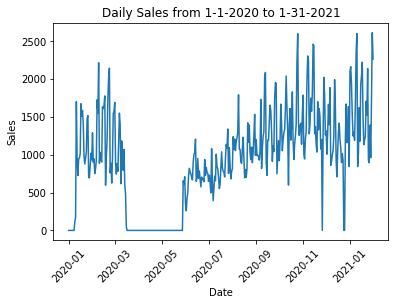

In [5]:
sns.lineplot(x='Date', y='Sales', data=df)
plt.title('Daily Sales from 1-1-2020 to 1-31-2021');
plt.xticks(rotation=45);

However, we can make this more detailed by stratifying our sales by weekdays and weekends. As we can see below, of course weekends total more profit.

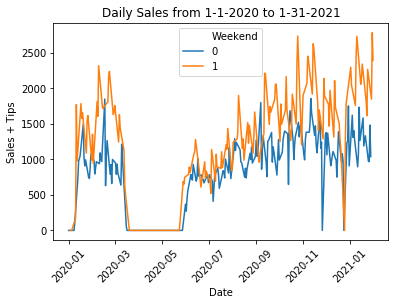

In [6]:
# assigning new `Weekend` column
df = df.assign(**{'Weekend': df['Date'].apply(lambda x: 1 if x.weekday() in [4,5,6] else 0)})

# plotting
sns.lineplot(x='Date', y='Sales + Tips', hue='Weekend', data=df)
plt.title('Daily Sales from 1-1-2020 to 1-31-2021');
plt.xticks(rotation=45);

#### Defining a Plotting Function

Here, we will construct a versatile function for plotting by other columns according to aggregation function, date frequency, date range, and etc.

In [13]:
def plotDf(df, col='Sales + Tips', agg='sum', freq='d', lower=None, upper=None, hue=None, rotation=45, title=None):
    """
    df: input dataframe.
    col: column of dataframe to plot along y-axis. Default = 'Sales + Tips'.
    freq: frequency of date label along x-axis. Default = 'd'.
    agg: method to compute y-axis values. Default = 'sum'.
    lower: lower date bound.
    upper: upper date bound.
    hue: column of dataframe to create subgroups.
    rotation: rotation of x-ticks labels. Default = 45.
    """
    
    temp = df.copy()
    lower = pd.to_datetime(lower)
    upper = pd.to_datetime(upper)
    
    # input of lower and upper dates
    if lower != None and upper != None:
        temp = temp[(temp['Date'] >= lower) & (temp['Date'] <= upper)]
        
    # input of lower only
    elif lower != None:
        temp = temp[temp['Date'] >= lower]
    
    # if `freq` is other than daily, group the dates
    if freq != 'd':
        temp['Date'] = pd.DatetimeIndex(temp['Date'] - pd.to_timedelta(7, unit='d'))
        # if `hue` is selected, groupby both `Date` and `Hue`
        if hue: 
            temp = temp.groupby([pd.Grouper(key='Date', freq=freq), hue])[col].agg(agg).reset_index().sort_values('Date')
        else:
            temp = temp.groupby(pd.Grouper(key='Date', freq=freq))[col].agg(agg).reset_index().sort_values('Date')

    # generating daily plot according to `col`, `hue`, and `rotation`
    sns.lineplot(x='Date', y=col, hue=hue, data=temp)
    
    if title == None:
        plt.title('{} of \'{}\' by {}'.format(
            agg.capitalize(), 
            col, 
            (lambda x: 'Day' if x.upper()[0]=='D' else ('Week' if x.upper()[0]=='W' else 'Month'))(freq))
        )
    else:
        plt.title(title)
        
    plt.xticks(rotation=rotation);
    

#### Average Sales by Week Broken by Weekend

Here, we are testing the method with its various arguments.

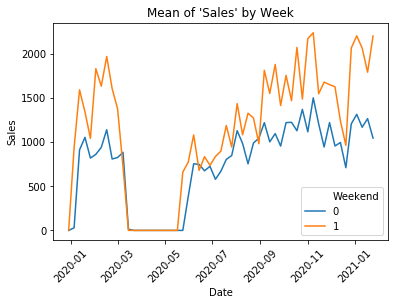

In [14]:
plotDf(df, col='Sales', freq='W', hue='Weekend', agg='mean')

# Restaurant Analysis
In this section, we have three primary goals, (2) and (3) of which were desired of by the restaurant owner herself:

**1. Determine whether customers tend to be more empathetic and give more tips after the first wave of COVID-19.**

**2. Determine how to reduce menu itemization while minimizing loss.**

**3. How to approach the pricing on certain menu items, namely rice and salad dishes.**

### 1. Customer `Tip` Support?

We can grasp a general sense of customer support / gratitude by viewing customer `Tips` over time.

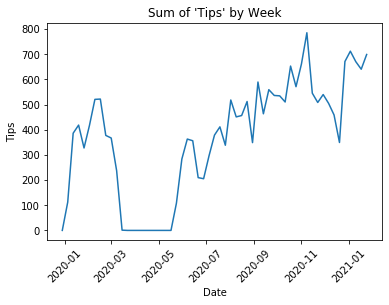

In [15]:
plotDf(df, col='Tips', freq='W')

This graph gives us a general sense of total customer support using weekly sum of `Tips` as a metric. Although sum of `Tips` gives us some information, it does not answer the question of whether or not a higher *proportion* of customers are supporting the restaurant over time.

#### Percentage of `Tips` of Total `Sales + Tips` by Week

We want to determine whether or not a higher *proportion* of customers are giving additional aid or support during or shortly after the large waves of COVID-19 cases. We can do this by redefining our approach and look at the **percentage of `Sales + Tips` that are tips**.

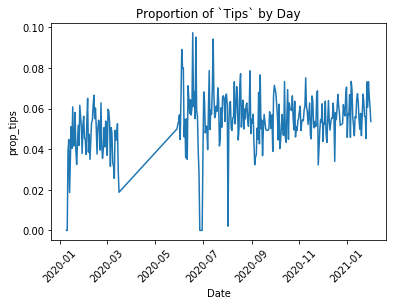

In [51]:
# creating new column for percentage of `Tips` of total `Sales + Tips`
prop_tips = df['Tips'] / df['Sales + Tips']
df = df.assign(**{'prop_tips': prop_tips})

plotDf(df, col='prop_tips', title='Proportion of `Tips` by Day')

Seeing this graph, it appears that the proportion of `Tips` are in fact higher after the initial surge of COVID-19. In order to test this statistically, a **2-Sample T-Test**. We will use 1 month's worth of data before and after the closure of this restaurant. 

*Note: we will use after-restaurant-closure data from roughly August 2020 to September 2020 because the months preceeding have several outlying observations*

In [49]:
before = df[(df['Date'] > pd.to_datetime('January 15 2020')) & (df['Date'] < pd.to_datetime('February 15 2020'))]
after = df[(df['Date'] > pd.to_datetime('August 2 2020')) & (df['Date'] < pd.to_datetime('September 2 2020'))]

### 1 cont'd. Hypothesis Testing: 2-Sample T-Test

**Null Hypothesis**: The mean percentage of tips before the COVID-19 closure is the **same** as the mean percentage of tips after the COVID-19 closure.

**Alternative Hypothesis**: The mean percentage of tips after the COVID-19 closure **greater than** the mean percentage of tips before the COVID-19 closure.

We will use a significance level of **alpha = 0.05**.

In [50]:
# combining before and after statistics into a single dataframe for easier viewing
before_stats = before.describe().loc[['count', 'mean', 'std'], 'prop_tips']
after_stats = after.describe().loc[['count', 'mean', 'std'], 'prop_tips']
stats = pd.DataFrame({'before': before_stats, 'after': after_stats})
stats

,before,after
count,30.000000,30.000000
mean,0.048912,0.058789
std,0.009449,0.008897


#### Test Statistic

In [54]:
a_n = stats.loc['count', 'after']
a_mean = stats.loc['mean', 'after']
a_std = stats.loc['std', 'after']

b_n = stats.loc['count', 'before']
b_mean = stats.loc['mean', 'before']
b_std = stats.loc['std', 'before']

t_stat = (
    (a_mean - b_mean) / (np.sqrt(a_std**2/a_n + b_std**2/b_n))
)
t_stat

4.168159303241813

#### Observed p-value

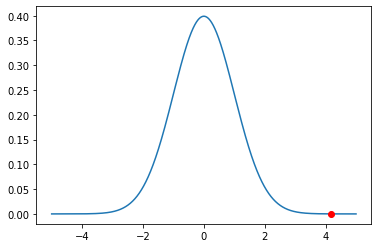

1.53534652498537e-05

In [65]:
x_axis = np.arange(-5, 5, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1))
plt.plot(t_stat,0,'ro')
plt.show()

norm.cdf(-t_stat)

#### Conclusion

With a **p-value of 1.535e-5 < 0.05, we reject our null hypothesis**. We found statistically significanty evidence that the true mean percentage of tips is higher after the COVID-19 closure than before.

### 2. Reducing Menu Size
In this section, we will reduce the menu size by looking at three particular items: **Egg Rolls**, **Chicken Skewers**, and **Firecracker Shrimp**. Currently, they have quantity choices for customers to choose from. A common complaint by the business owner is that it becomes hassling and awkward to clarify with the customer, "how many pieces would you like for...?" We will view previous months' sales history for these quantity choices to determine the optimal quantities.

In [126]:
modifiers_09_20 = pd.read_csv('.\data\Modifiers 09-01-2020.csv')
modifiers_09_20

,Appetizers,Qty,Total
0,(3),181,"1,252.75"
1,Egg Rolls (3),181,0.00
2,(2),170,837.80
3,Egg Rolls (3),170,0.00
4,(3),75,668.57
5,Chicken Skewers (3),75,0.00
6,(2),62,430.90
7,Chicken Skewers (3),62,0.00
8,(4),58,402.06
9,Firecracker Shrimp (5),58,0.00


### Data Cleaning / Processing

In [143]:
def clean_df2(df, month):
    
    temp = df.copy()
    
    # dropping `Qty`
    temp = temp.drop('Qty', axis=1)
    
    # renaming rows
    temp.loc[0, 'Appetizers'] = 'Egg Rolls (3)'
    temp.loc[2, 'Appetizers'] = 'Egg Rolls (2)'
    temp.loc[4, 'Appetizers'] = 'Chicken Skewers (3)'
    temp.loc[6, 'Appetizers'] = 'Chicken Skewers (2)'
    temp.loc[8, 'Appetizers'] = 'Firecracker Shrimp (4)'
    temp.loc[10, 'Appetizers'] = 'Firecracker Shrimp (7)'
    
    # dropping all rows that do not contain pattern
    temp = temp[temp['Appetizers'].str.contains('Egg|Chicken|Firecracker')]
    temp = temp.iloc[range(0,len(temp),2),]
    
    # cleaning `Total` column
    def clean_total(val):
        val = val.replace(',','')
        return float(val)
    temp['Total'] = temp['Total'].apply(clean_total)
    
    # adding `Month` Column
    temp = temp.assign(**{'Month': pd.to_datetime('{}-01-2020'.format(month))})
    
    return temp

In [151]:
df2 = pd.DataFrame()

# iterating through our 3 csv's
for i in ('09','10','11'):
    
    # cleaning and joining each month's modifiers from September 2020 to December 2020
    temp = pd.read_csv('.\data\Modifiers {}-01-2020.csv'.format(i))
    df2 = pd.concat([df2, clean_df2(temp, month=i)])

df2 = df2.reset_index(drop=True)

In [159]:
df2.groupby(['Appetizers', 'Month'])['Appetizers', 'Total'].agg('sum')

Total
Appetizers             Month              
Chicken Skewers (2)    2020-09-01   430.90
                       2020-10-01   429.86
                       2020-11-01   335.69
Chicken Skewers (3)    2020-09-01   668.57
                       2020-10-01   615.76
                       2020-11-01   456.45
Egg Rolls (2)          2020-09-01   837.80
                       2020-10-01   721.22
                       2020-11-01   979.95
Egg Rolls (3)          2020-09-01  1252.75
                       2020-10-01  1147.45
                       2020-11-01   706.12
Firecracker Shrimp (4) 2020-09-01   402.06
                       2020-10-01   408.31
                       2020-11-01   283.56
Firecracker Shrimp (7) 2020-09-01   405.15
                       2020-10-01   284.70
                       2020-11-01   328.50

Viewing this new table we can see that consistently over the months of September 2020 to November 2020, **Egg Rolls (3) and Chicken Skewers(3) make more than its other quantity**. The only item that did not see this consistent trend was Firecracker Shrimp, and therefore, it was suggested that the business owner could settle for whatever quantity she desired. She decided to go with an intermediate quantity of 5.

### 3. Price Changes